In [1]:
%load_ext autoreload
%autoreload 2

In [2]:



import glob
import itertools
import math
import os

import igraph as ig
import leidenalg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import khtools


ksize = 21
moltype = 'DNA'

ignore_abundance = False
downsample = False


# Defaults from 'sourmash index'

bf_size = 1e5
n_children = 2
scaled = False

n_neighbors = 3

try:
    import scanpy.api as sc
except FutureWarning:
    import scanpy as sc

sc.logging.print_versions()


from sourmash import signature as sig
from sourmash.compare import compare_all_pairs
from sourmash.sbt import Leaf
from sourmash.sbtmh import SigLeaf, create_sbt_index
from sourmash import sourmash_args
from sourmash.logging import notify

import umap

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
annotations = pd.read_csv('https://github.com/czbiohub/tabula-muris/raw/master/00_data_ingest/18_global_annotation_csv/annotations_facs.csv', 
                          index_col='cell')
annotations.index = annotations.index.str.replace('.', '-')
annotations.columns = annotations.columns.str.replace('.', '_')
annotations['sample_id'] = annotations.index
annotations = annotations.fillna("NA")
print(annotations.shape)
annotations.head()

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(44949, 24)


,Neurog3>0_raw,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster_ids,free_annotation,mouse_id,mouse_sex,plate_barcode,subsetA,...,subsetC_cluster_ids,subsetD,subsetD_cluster_ids,subsetE,subsetE_cluster_ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2,sample_id
cell,,,,,,,,,,,,,,,,,,,,,
A1-B000610-3_56_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-7.182841,-10.895094,A1-B000610-3_56_F-1-1
A1-B002764-3_38_F-1-1,NA,NA,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,NA,...,NA,NA,NA,NA,NA,NA,Bladder,4.199059,-11.050240,A1-B002764-3_38_F-1-1
A1-B002771-3_39_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-11.995435,-7.325534,A1-B002771-3_39_F-1-1
A1-D041914-3_8_M-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-6.820022,-14.174246,A1-D041914-3_8_M-1-1
A1-D042253-3_9_M-1-1,NA,NA,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-24.163538,-7.499349,A1-D042253-3_9_M-1-1


In [4]:
bladder_annotations = annotations.query('tissue == "Bladder"')
print(bladder_annotations.shape)
bladder_annotations.head()

(1378, 24)


,Neurog3>0_raw,Neurog3>0_scaled,cell_ontology_class,cell_ontology_id,cluster_ids,free_annotation,mouse_id,mouse_sex,plate_barcode,subsetA,...,subsetC_cluster_ids,subsetD,subsetD_cluster_ids,subsetE,subsetE_cluster_ids,subtissue,tissue,tissue_tSNE_1,tissue_tSNE_2,sample_id
cell,,,,,,,,,,,,,,,,,,,,,
A1-B000610-3_56_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_56_F,F,B000610,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-7.182841,-10.895094,A1-B000610-3_56_F-1-1
A1-B002764-3_38_F-1-1,NA,NA,bladder urothelial cell,CL:1001428,3,Luminal bladder epithelial cell,3_38_F,F,B002764,NA,...,NA,NA,NA,NA,NA,NA,Bladder,4.199059,-11.050240,A1-B002764-3_38_F-1-1
A1-B002771-3_39_F-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_39_F,F,B002771,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-11.995435,-7.325534,A1-B002771-3_39_F-1-1
A1-D041914-3_8_M-1-1,NA,NA,bladder cell,CL:1001319,5,Bladder mesenchymal cell,3_8_M,M,D041914,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-6.820022,-14.174246,A1-D041914-3_8_M-1-1
A1-D042253-3_9_M-1-1,NA,NA,bladder cell,CL:1001319,2,Bladder mesenchymal cell,3_9_M,M,D042253,NA,...,NA,NA,NA,NA,NA,NA,Bladder,-24.163538,-7.499349,A1-D042253-3_9_M-1-1


In [5]:

folder = '/home/olga/pureScratch/olgabot-maca/facs/sourmash/'


all_signatures = glob.glob(f'{folder}/*.sig')
basenames = [os.path.basename(x) for x in all_signatures]
basenames[:10]

['A1-B000127-3_38_F-1-1_S1.sig',
 'A1-B000126-3_39_F-1-1_S289.sig',
 'A1-B000167-3_56_F-1-1_S228.sig',
 'A1-B000168-3_57_F-1-1_S177.sig',
 'A1-B000412-3_56_F-1-1_S110.sig',
 'A1-B000610-3_56_F-1-1_S28.sig',
 'A1-B000633-3_56_F-1-1_S266.sig',
 'A1-B000634-3_56_F-1-1_S253.sig',
 'A1-B000636-3_56_F-1-1_S126.sig',
 'A1-B000826-3_39_F-1-1_S167.sig']

In [6]:
%%time

bladder_files = list(itertools.chain(*[[x for x in basenames if x.startswith(cell_id)] for cell_id in bladder_annotations.index]))
len(bladder_files)


CPU times: user 9.44 s, sys: 0 ns, total: 9.44 s
Wall time: 9.46 s


In [7]:
bladder_files[:10]

['A1-B000610-3_56_F-1-1_S28.sig',
 'A1-B002764-3_38_F-1-1_S291.sig',
 'A1-B002771-3_39_F-1-1_S242.sig',
 'A1-D041914-3_8_M-1-1_S269.sig',
 'A1-D042253-3_9_M-1-1_S43.sig',
 'A1-MAA000487-3_10_M-1-1_S264.sig',
 'A10-B000610-3_56_F-1-1_S38.sig',
 'A10-B002764-3_38_F-1-1_S22.sig',
 'A10-B002771-3_39_F-1-1_S249.sig',
 'A10-D041914-3_8_M-1-1_S279.sig']

In [8]:
bladder_full_path = [folder + x for x in bladder_files]
print(len(bladder_full_path))
bladder_full_path[:10]

1270


['/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-B000610-3_56_F-1-1_S28.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-B002764-3_38_F-1-1_S291.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-B002771-3_39_F-1-1_S242.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-D041914-3_8_M-1-1_S269.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-D042253-3_9_M-1-1_S43.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A1-MAA000487-3_10_M-1-1_S264.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-B000610-3_56_F-1-1_S38.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-B002764-3_38_F-1-1_S22.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-B002771-3_39_F-1-1_S249.sig',
 '/home/olga/pureScratch/olgabot-maca/facs/sourmash/A10-D041914-3_8_M-1-1_S279.sig']

In [9]:
%%time

ksize = 21
moltype = "DNA"
ignore_abundance = True


bladder_signatures = []
for filename in bladder_full_path:
     bladder_signatures.extend(sig.load_signatures(filename, ksize=ksize, select_moltype="DNA"))
print(len(bladder_signatures))
bladder_signatures[:5]

1270
CPU times: user 27.7 s, sys: 176 ms, total: 27.9 s
Wall time: 31 s


In [10]:
cells = [x.name().split("_S")[0] for x in bladder_signatures]
print(len(cells))
cells[:10]

1270


['A1-B000610-3_56_F-1-1',
 'A1-B002764-3_38_F-1-1',
 'A1-B002771-3_39_F-1-1',
 'A1-D041914-3_8_M-1-1',
 'A1-D042253-3_9_M-1-1',
 'A1-MAA000487-3_10_M-1-1',
 'A10-B000610-3_56_F-1-1',
 'A10-B002764-3_38_F-1-1',
 'A10-B002771-3_39_F-1-1',
 'A10-D041914-3_8_M-1-1']

In [11]:
%%time

bladder_similarities_ignore_abundanceTrue = compare_all_pairs(bladder_signatures, ignore_abundance=True, n_jobs=32)

Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 1269 done in 0.00000 secondstting similarities matrix for index 21 done in 0.00064 secondsSetting similarities matrix for index 29 done in 0.00086 seconds


CPU times: user 6.43 s, sys: 2.26 s, total: 8.68 s
Wall time: 9.46 s


Time taken to compare all pairs parallely is 9.45965 seconds 


In [12]:
bladder_similarities_ignore_abundanceTrue

memmap([[1.   , 0.018, 0.072, ..., 0.088, 0.088, 0.06 ],
        [0.018, 1.   , 0.012, ..., 0.014, 0.014, 0.006],
        [0.072, 0.012, 1.   , ..., 0.1  , 0.124, 0.076],
        ...,
        [0.088, 0.014, 0.1  , ..., 1.   , 0.1  , 0.146],
        [0.088, 0.014, 0.124, ..., 0.1  , 1.   , 0.106],
        [0.06 , 0.006, 0.076, ..., 0.146, 0.106, 1.   ]])

In [13]:
bladder_similarities_ignore_abundanceTrue_df = pd.DataFrame(bladder_similarities_ignore_abundanceTrue, index=cells, columns=cells)
bladder_similarities_ignore_abundanceTrue_df.head()

,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,A1-B002771-3_39_F-1-1,A1-D041914-3_8_M-1-1,A1-D042253-3_9_M-1-1,A1-MAA000487-3_10_M-1-1,A10-B000610-3_56_F-1-1,A10-B002764-3_38_F-1-1,A10-B002771-3_39_F-1-1,A10-D041914-3_8_M-1-1,...,P7-D042253-3_9_M-1-1,P7-MAA000487-3_10_M-1-1,P8-B000610-3_56_F-1-1,P8-B002764-3_38_F-1-1,P8-D042253-3_9_M-1-1,P8-MAA000487-3_10_M-1-1,P9-B000610-3_56_F-1-1,P9-B002771-3_39_F-1-1,P9-D042253-3_9_M-1-1,P9-MAA000487-3_10_M-1-1
A1-B000610-3_56_F-1-1,1.000,0.018,0.072,0.098,0.090,0.102,0.086,0.058,0.088,0.096,...,0.096,0.076,0.084,0.052,0.104,0.056,0.090,0.088,0.088,0.060
A1-B002764-3_38_F-1-1,0.018,1.000,0.012,0.028,0.014,0.020,0.008,0.008,0.014,0.018,...,0.006,0.012,0.012,0.010,0.008,0.014,0.016,0.014,0.014,0.006
A1-B002771-3_39_F-1-1,0.072,0.012,1.000,0.094,0.110,0.106,0.082,0.060,0.086,0.126,...,0.108,0.100,0.074,0.054,0.118,0.064,0.076,0.100,0.124,0.076
A1-D041914-3_8_M-1-1,0.098,0.028,0.094,1.000,0.078,0.100,0.078,0.056,0.084,0.100,...,0.086,0.080,0.080,0.056,0.098,0.062,0.088,0.074,0.104,0.064
A1-D042253-3_9_M-1-1,0.090,0.014,0.110,0.078,1.000,0.114,0.086,0.056,0.088,0.106,...,0.110,0.096,0.076,0.076,0.126,0.082,0.104,0.092,0.120,0.102


In [14]:
similarities = pd.DataFrame(bladder_similarities_ignore_abundanceTrue, index=cells, columns=cells)
print(similarities.shape)
similarities.head()

(1270, 1270)


,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,A1-B002771-3_39_F-1-1,A1-D041914-3_8_M-1-1,A1-D042253-3_9_M-1-1,A1-MAA000487-3_10_M-1-1,A10-B000610-3_56_F-1-1,A10-B002764-3_38_F-1-1,A10-B002771-3_39_F-1-1,A10-D041914-3_8_M-1-1,...,P7-D042253-3_9_M-1-1,P7-MAA000487-3_10_M-1-1,P8-B000610-3_56_F-1-1,P8-B002764-3_38_F-1-1,P8-D042253-3_9_M-1-1,P8-MAA000487-3_10_M-1-1,P9-B000610-3_56_F-1-1,P9-B002771-3_39_F-1-1,P9-D042253-3_9_M-1-1,P9-MAA000487-3_10_M-1-1
A1-B000610-3_56_F-1-1,1.000,0.018,0.072,0.098,0.090,0.102,0.086,0.058,0.088,0.096,...,0.096,0.076,0.084,0.052,0.104,0.056,0.090,0.088,0.088,0.060
A1-B002764-3_38_F-1-1,0.018,1.000,0.012,0.028,0.014,0.020,0.008,0.008,0.014,0.018,...,0.006,0.012,0.012,0.010,0.008,0.014,0.016,0.014,0.014,0.006
A1-B002771-3_39_F-1-1,0.072,0.012,1.000,0.094,0.110,0.106,0.082,0.060,0.086,0.126,...,0.108,0.100,0.074,0.054,0.118,0.064,0.076,0.100,0.124,0.076
A1-D041914-3_8_M-1-1,0.098,0.028,0.094,1.000,0.078,0.100,0.078,0.056,0.084,0.100,...,0.086,0.080,0.080,0.056,0.098,0.062,0.088,0.074,0.104,0.064
A1-D042253-3_9_M-1-1,0.090,0.014,0.110,0.078,1.000,0.114,0.086,0.056,0.088,0.106,...,0.110,0.096,0.076,0.076,0.126,0.082,0.104,0.092,0.120,0.102


In [15]:
! ls -lha /home/olga/pureScratch/olgabot-maca/facs/

total 122G
drwxrwxr-x 1 olga olga    0 Aug 16 15:00 .
drwxrwxr-x 1 olga olga    0 Aug  1 01:58 ..
-rw-rw-r-- 1 olga olga 9.0M Aug 20 06:16 bladder_compare_k21_ignoreabundanceTrue.csv
drwxrwxr-x 1 olga olga    0 Aug 12 06:29 .sbt.tabula-muris-k21
drwxrwxr-x 1 olga olga    0 Aug  1 16:45 sourmash
-rw-rw-r-- 1 olga olga  47G Aug  6 19:18 sourmash_compare_k21.csv
-rw-rw-r-- 1 olga olga  14G Aug  7 11:51 sourmash_compare_k21_ignore_abundance.csv
-rw-rw-r-- 1 olga olga  48G Aug  6 19:21 sourmash_compare_k31.csv
-rw-rw-r-- 1 olga olga 2.5K Aug  9 14:30 sourmash_compare_k31.hdf5
-rw-rw-r-- 1 olga olga  14G Aug  7 11:51 sourmash_compare_k31_ignore_abundance.csv
drwxrwxr-x 1 olga olga    0 Aug 15 10:26 sourmash_compute_all
drwxrwxr-x 1 olga olga    0 Aug 16 16:30 sourmash_tissues
-rw-rw-r-- 1 olga olga  13M Aug 12 06:50 tabula-muris-k21.sbt.json


In [16]:
similarities.to_csv("/home/olga/pureScratch/olgabot-maca/facs/bladder_compare_k21_ignoreabundanceTrue.csv")

In [17]:
bladder_annotations = annotations.loc[similarities.index]

In [18]:
color_cols = [#'tissue', 'subtissue', 
              'cell_ontology_class', 'mouse_id', 'mouse_sex', 'plate_barcode', 'free_annotation']
palette_names = [#'tab20', 'tab10',
                 'Set2', 'husl', 'Paired', 'Set2', 'Set1']
palettes = dict(zip(color_cols, palette_names))
palettes

{'cell_ontology_class': 'Set2',
 'mouse_id': 'husl',
 'mouse_sex': 'Paired',
 'plate_barcode': 'Set2',
 'free_annotation': 'Set1'}

In [19]:
graphs = {}
positions = {}

NameError: name 'savefig' is not defined

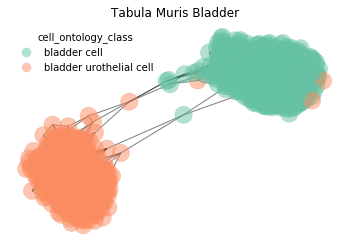

In [20]:
%%time


n_neighbors = 5
figure_folder = 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/'
figure_prefix = f'molecule={moltype}_ksize={ksize}_ignore-abundance={ignore_abundance}'
title = 'Tabula Muris Bladder'

key = f'k{ksize}_without_abundance_neighbors{n_neighbors}'


g, pos = khtools.knn.build_graph_and_plot(similarities, bladder_annotations, n_neighbors,
                                          color_cols, palettes, figure_folder, figure_prefix, title)

graphs[key] = g
positions[key] = pos

NameError: name 'savefig' is not defined

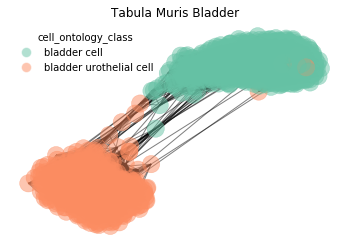

In [21]:
%%time

n_neighbors = 15
figure_folder = 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/'
figure_prefix = f'molecule={moltype}_ksize={ksize}_ignore-abundance={ignore_abundance}'
title = 'Tabula Muris Bladder'


key = f'k{ksize}_without_abundance_neighbors{n_neighbors}'

g, pos = khtools.knn.build_graph_and_plot(similarities, bladder_annotations, n_neighbors,
                                          color_cols, palettes, figure_folder, figure_prefix, title)

graphs[key] = g
positions[key] = pos

In [22]:
%%time

bladder_similarities_ignore_abundanceFalse = compare_all_pairs(bladder_signatures, ignore_abundance=False, n_jobs=32)
bladder_similarities_ignore_abundanceFalse = pd.DataFrame(bladder_similarities_ignore_abundanceFalse, index=cells, columns=cells)
bladder_similarities_ignore_abundanceFalse.head()

Created memmapped siglist
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 1269 done in 0.00001 seconds


CPU times: user 7.26 s, sys: 1.36 s, total: 8.63 s
Wall time: 17.6 s


Time taken to compare all pairs parallely is 17.63312 seconds 


## Make Tidy dataframe to compare with and without abundance

In [23]:
bladder_ignore_abundance_true_tidy = bladder_similarities_ignore_abundanceTrue_df.unstack().reset_index()
bladder_ignore_abundance_true_tidy = bladder_ignore_abundance_true_tidy.rename(columns={'level_0': 'cell1', 'level_1': 'cell2', 
                                                                                          0:'similarity_without_abundance'})
bladder_ignore_abundance_true_tidy.head()

,cell1,cell2,similarity_without_abundance
0,A1-B000610-3_56_F-1-1,A1-B000610-3_56_F-1-1,1.000
1,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,0.018
2,A1-B000610-3_56_F-1-1,A1-B002771-3_39_F-1-1,0.072
3,A1-B000610-3_56_F-1-1,A1-D041914-3_8_M-1-1,0.098
4,A1-B000610-3_56_F-1-1,A1-D042253-3_9_M-1-1,0.090


In [24]:
bladder_ignore_abundance_false_tidy = bladder_similarities_ignore_abundanceFalse.unstack().reset_index()
bladder_ignore_abundance_false_tidy = bladder_ignore_abundance_false_tidy.rename(columns={'level_0': 'cell1', 'level_1': 'cell2', 
                                                                                          0:'similarity_with_abundance'})
bladder_ignore_abundance_false_tidy.head()

,cell1,cell2,similarity_with_abundance
0,A1-B000610-3_56_F-1-1,A1-B000610-3_56_F-1-1,1.000000
1,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,0.228460
2,A1-B000610-3_56_F-1-1,A1-B002771-3_39_F-1-1,0.245190
3,A1-B000610-3_56_F-1-1,A1-D041914-3_8_M-1-1,0.454728
4,A1-B000610-3_56_F-1-1,A1-D042253-3_9_M-1-1,0.231834


In [25]:
merge_cols = ['cell1', 'cell2']

bladder_similarities_tidy = bladder_ignore_abundance_true_tidy.merge(bladder_ignore_abundance_false_tidy, on=merge_cols)
bladder_similarities_tidy = bladder_similarities_tidy.join(annotations['cell_ontology_class'], on='cell1')
bladder_similarities_tidy = bladder_similarities_tidy.rename(columns={'cell_ontology_class': 'cell_ontology_class_cell1'})
bladder_similarities_tidy = bladder_similarities_tidy.join(annotations['cell_ontology_class'], on='cell2', rsuffix='_cell2')
print(bladder_similarities_tidy.shape)
bladder_similarities_tidy.head()


(1612900, 6)


,cell1,cell2,similarity_without_abundance,similarity_with_abundance,cell_ontology_class_cell1,cell_ontology_class
0,A1-B000610-3_56_F-1-1,A1-B000610-3_56_F-1-1,1.000,1.000000,bladder cell,bladder cell
1,A1-B000610-3_56_F-1-1,A1-B002764-3_38_F-1-1,0.018,0.228460,bladder cell,bladder urothelial cell
2,A1-B000610-3_56_F-1-1,A1-B002771-3_39_F-1-1,0.072,0.245190,bladder cell,bladder cell
3,A1-B000610-3_56_F-1-1,A1-D041914-3_8_M-1-1,0.098,0.454728,bladder cell,bladder cell
4,A1-B000610-3_56_F-1-1,A1-D042253-3_9_M-1-1,0.090,0.231834,bladder cell,bladder cell


In [27]:
# khtools.s3_utils.write_s3(bladder_similarities_tidy, 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/similarities_tidy.csv', index=False)

In [34]:
# bladder_similarities_tidy.to_csv()

In [35]:
bladder_similarities_tidy.sample(5)

,cell1,cell2,similarity_without_abundance,similarity_with_abundance,cell_ontology_class_cell1,cell_ontology_class
263719,C20-B002764-3_38_F-1-1,K15-MAA000487-3_10_M-1-1,0.094,0.363473,bladder urothelial cell,bladder urothelial cell
1034263,K12-B000610-3_56_F-1-1,G1-B002771-3_39_F-1-1,0.096,0.067341,bladder urothelial cell,bladder cell
530683,F12-D041914-3_8_M-1-1,N3-MAA000487-3_10_M-1-1,0.102,0.284852,bladder cell,bladder cell
648803,G17-D041914-3_8_M-1-1,N6-D042253-3_9_M-1-1,0.106,0.070647,bladder urothelial cell,bladder cell
1454001,O16-D041914-3_8_M-1-1,O11-B000610-3_56_F-1-1,0.120,0.429352,bladder urothelial cell,bladder urothelial cell


In [36]:
cell1 = 'A1-B000610-3_56_F-1-1'

sig1 = [x for x in bladder_signatures if x.name().startswith(cell1)][0]
sig1

SourmashSignature('A1-B000610-3_56_F-1-1_S28', 280b9bab)

In [37]:
cell2 = 'A1-B002764-3_38_F-1-1'

sig2 = [x for x in bladder_signatures if x.name().startswith(cell2)][0]
sig2

SourmashSignature('A1-B002764-3_38_F-1-1_S291', ef185816)

In [38]:
sig1.minhash?

Type:        MinHash
String form: <sourmash._minhash.MinHash object at 0x7f2369f4bcb0>
Length:      500
File:        ~/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/sourmash-2.0.2.dev130+g0670d8a-py3.7-linux-x86_64.egg/sourmash/_minhash.cpython-37m-x86_64-linux-gnu.so
Docstring:   <no docstring>


Exception ignored in: <function AbstractBufferedFile.__del__ at 0x7f23966c99d8>
Traceback (most recent call last):
  File "/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/fsspec/spec.py", line 1146, in __del__
    self.close()
  File "/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/fsspec/spec.py", line 1123, in close
    self.flush(force=True)
  File "/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/fsspec/spec.py", line 995, in flush
    self._initiate_upload()
  File "/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/s3fs/core.py", line 966, in _initiate_upload
    raise translate_boto_error(e)
PermissionError: The AWS Access Key Id you provided does not exist in our records.


NameError: name 'savefig' is not defined

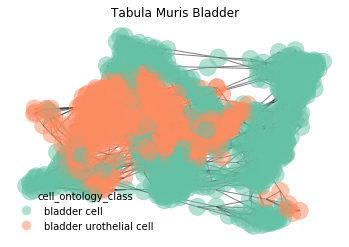

In [39]:
%%time


n_neighbors = 5
ignore_abundance = False
figure_folder = 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/'
figure_prefix = f'molecule={moltype}_ksize={ksize}_ignore-abundance={ignore_abundance}'
title = 'Tabula Muris Bladder'


key = f'k{ksize}_with_abundance_neighbors{n_neighbors}'


g, pos = khtools.knn.build_graph_and_plot(bladder_similarities_ignore_abundanceFalse, 
                                          bladder_annotations, n_neighbors,
                                          color_cols, palettes, figure_folder, figure_prefix, title)

# graphs[key] = g
# positions[key] = pos

NameError: name 'savefig' is not defined

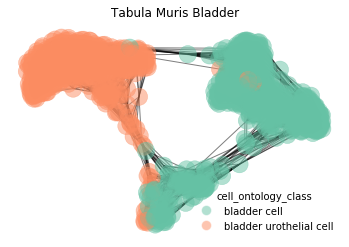

In [40]:
%%time

key = f'k{ksize}_with_abundance'

n_neighbors = 15
ignore_abundance = False
figure_folder = 's3://kmer-hashing/tabula-muris/n_hashes=500/bladder/'
figure_prefix = f'molecule={moltype}_ksize={ksize}_ignore-abundance={ignore_abundance}'
title = 'Tabula Muris Bladder'

g, pos = khtools.knn.build_graph_and_plot(bladder_similarities_ignore_abundanceFalse, 
                                          bladder_annotations, n_neighbors,
                                          color_cols, palettes, figure_folder, figure_prefix, title)

# graphs[key] = g
# positions[key] = pos

In [41]:
folder

'/home/olga/pureScratch/olgabot-maca/facs/sourmash/'

In [42]:
bladder_folder = f'/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder/'
! mkdir -p $bladder_folder

for sigfile in bladder_full_path:
    basename = os.path.basename(sigfile)
    new_location = f"{bladder_folder}/{basename}"
    if not os.path.exists(new_location):
        ! ln -s $sigfile $new_location

ln: failed to create symbolic link '/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder//A1-B000610-3_56_F-1-1_S28.sig': File exists
ln: failed to create symbolic link '/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder//A1-B002764-3_38_F-1-1_S291.sig': File exists
ln: failed to create symbolic link '/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder//A1-B002771-3_39_F-1-1_S242.sig': File exists
ln: failed to create symbolic link '/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder//A1-D041914-3_8_M-1-1_S269.sig': File exists
ln: failed to create symbolic link '/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder//A1-D042253-3_9_M-1-1_S43.sig': File exists
ln: failed to create symbolic link '/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder//A1-MAA000487-3_10_M-1-1_S264.sig': File exists
ln: failed to create symbolic link '/home/olga/pureScratch/olgabot-maca/facs/sourmash_tissues/bladder//A10-B000610

## Try UMAP

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/olga/miniconda3/

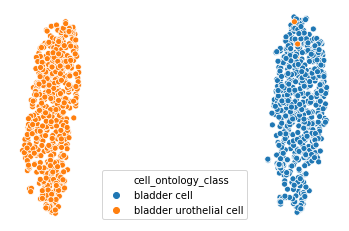

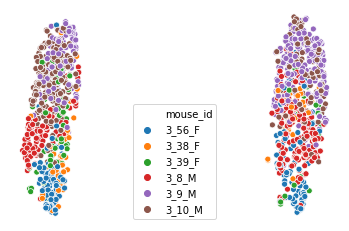

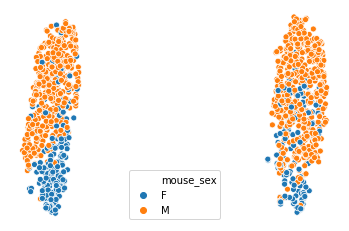

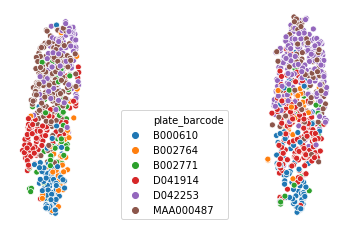

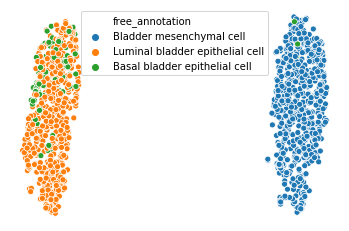

In [43]:
umapper = umap.UMAP(metric='precomputed', n_neighbors=5)
embedding = umapper.fit_transform(1-bladder_similarities_ignore_abundanceTrue)

x = embedding[:, 0]
y = embedding[:, 1]

for col in color_cols:
    hue = annotations.loc[cells, col]

    fig, ax = plt.subplots(figsize=(6, 4))

    sns.scatterplot(x, y, hue=hue)
    ax.axis('off')

/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/olga/miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../miniconda3/envs/sourmash-sbt2knn/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/olga/miniconda3/

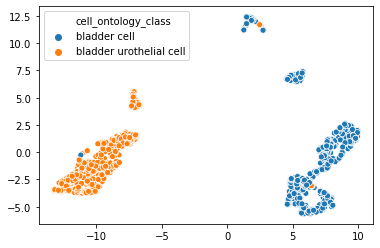

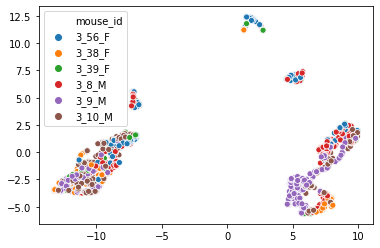

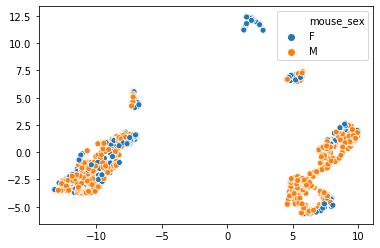

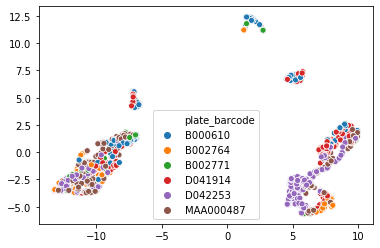

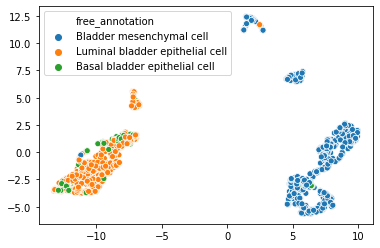

In [44]:
umapper = umap.UMAP(metric='precomputed', n_neighbors=5)
embedding = umapper.fit_transform(1-bladder_similarities_ignore_abundanceFalse)


x = embedding[:, 0]
y = embedding[:, 1]

for col in color_cols:
    hue = annotations.loc[cells, col]

    fig, ax = plt.subplots(figsize=(6, 4))

    sns.scatterplot(x, y, hue=hue)

### Make python-igraph for Leiden clustering

In [45]:
graphs

{}

In [46]:
g = graphs['k21_without_abundance_neighbors15']

g_directed = g.to_directed()


igraph = ig.Graph(directed=True)
nodes = [node for node in g_directed.nodes()]
igraph.add_vertices(nodes)  # this adds n_leaves vertices
igraph.add_edges([(u, v) for (u, v) in g_directed.edges()])
igraph.es['weight'] = [bladder_similarities_ignore_abundanceTrue_df.loc[u, v] for (u, v) in g_directed.edges()]

parition_type = leidenalg.RBConfigurationVertexPartition
partition = leidenalg.find_partition(igraph, partition_type)
# store output into adata.obs
groups = np.array(partition.membership)

KeyError: 'k21_without_abundance_neighbors15'

In [ ]:
np.unique(groups)

In [ ]:
leiden_result = pd.Series(groups, index=nodes)
leiden_result

In [ ]:
groups.shape

In [ ]:
umapper = umap.UMAP(metric='precomputed', n_neighbors=15)
embedding = umapper.fit_transform(1-bladder_similarities_ignore_abundanceTrue_df)


x = embedding[:, 0]
y = embedding[:, 1]

hue = pd.Series(groups).astype(str)


sns.scatterplot(x, y, hue=leiden_result.astype(int))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_true_names = bladder_annotations.loc[bladder_similarities_ignore_abundanceTrue_df.index, 'cell_ontology_class']
y_true_names

In [ ]:
int_to_cell_ontology = dict((cell_ontology, i) for i, cell_ontology in enumerate(y_true.unique()))
y_true = y_true_names.map(int_to_cell_ontology)
y_true

In [ ]:
predicted_labels = list(np.unique(groups))
true_labels = list(y_true.unique())

labels = predicted_labels + true_labels
labels

confusion = pd.DataFrame(confusion_matrix(y_true, leiden_result))
# confusion = confusion.loc[true_labels, predicted_labels]
confusion

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_true, leiden_result, average='weighted')

## Import "traditional" rnaseq

In [ ]:


h5ad = '/home/olga/ibm_lg/tabula-muris-senis/maca-facs-re-processed-annotated-fixed-tissues.h5ad'

tms = sc.read_h5ad(h5ad)
tms

In [ ]:
tms

In [ ]:
tms_bladder_metadata = tms.obs.query('(tissue == "Bladder") & (age == "3m")')
tms_bladder_metadata = tms_bladder_metadata.replace('nan', np.nan)
print(tms_bladder_metadata.shape)
tms_bladder_metadata = tms_bladder_metadata.dropna(subset=['cell_ontology_class'])
print(tms_bladder_metadata.shape)
tms_bladder_metadata.head()

In [ ]:
bladder_adata = tms[tms_bladder_metadata.index, :]
bladder_adata

In [ ]:
sc.pl.umap(bladder_adata, color='cell_ontology_class')

In [ ]:
bladder_adata.X[:, bladder_adata.var['highly_variable']]

In [ ]:
bladder_adata_binarized.X.shape

In [ ]:
type(bladder_adata_binarized.X)

In [ ]:
X = bladder_adata_binarized.X.todense()
X[X > 1]

In [ ]:
bladder_adata_binarized = bladder_adata.copy()
X = bladder_adata_binarized.X
bladder_adata_binarized.X[X > 0] = 1
bladder_adata_binarized


sc.tl.umap(bladder_adata_binarized)

sc.pl.umap(bladder_adata_binarized, color='cell_ontology_class', use_raw=True)

## Filter undetected genes

In [ ]:
sc.pp.filter_cells(bladder_adata, min_genes=200)
sc.pp.filter_genes(bladder_adata, min_cells=3)

In [ ]:
bladder_adata

In [ ]:
bladder_adata.raw = bladder_adata
sc.pp.highly_variable_genes(bladder_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(bladder_adata)

In [ ]:
bladder_adata = bladder_adata[:, bladder_adata.var['highly_variable']]
bladder_adata

In [ ]:
sc.tl.umap(bladder_adata)

sc.pl.umap(bladder_adata, color='cell_ontology_class')

In [ ]:
bladder_adata.X

In [ ]:
bladder_adata.uns['neighbors']

In [ ]:
bladder_adata_binarized = bladder_adata.copy()
X = bladder_adata_binarized.X
bladder_adata_binarized.X[X > 0] = 1
bladder_adata_binarized


sc.tl.umap(bladder_adata_binarized)

sc.pl.umap(bladder_adata_binarized, color='cell_ontology_class', use_raw=True)